In [2]:
library("ape")
library("phytools")
library("caper")
library("geiger")
library("readxl")
library("tidyverse")

Loading required package: maps

Loading required package: MASS

Loading required package: mvtnorm

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::map()    masks maps::map()
✖ dplyr::select() masks MASS::select()
✖ dplyr::where()  masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
load_and_process_csv <- function(csv_filename) {
    df <- read.csv(csv_filename)
    rownames(df) <- df$species
    df$log_u <- log10(df$u_mean)
    df$log_u_year <- log10(df$u_mean_year)
    df$log_Ne <- log10(df$Ne)
    df$log_Ne.gen <- log10(df$Ne.gen)
    df$log_gen_year <- log10(df$generation_time_year)
    df = dplyr::select(df, species, log_u, log_u_year, log_Ne, log_Ne.gen, log_gen_year)
    return(df)
}

load_tree_and_modify_species_name <- function(tree_filename) {
    tree <- read.tree(tree_filename)
    # the tree should be both binary and ultrametric
    stopifnot(is.binary(tree)) 
    stopifnot(is.ultrametric(tree))
    # 126 species, 250 edges
    length(tree$tip.label) 
    # plot(tree)
    
    # replace all _ in tree species name to space
    for(nn in tree$tip.label){
      tmp <- stringr::str_replace_all(nn,'_', ' ')
      tree$tip.label <- 
        stringr::str_replace_all(tree$tip.label, nn, tmp)
    }
    return(tree)
}

trim_tree_branches <- function (tree, df) {
    # trim off tree branches corresponding to species that are not found in the dataframe
    name_check <- name.check(tree, df)
    new_tree <- drop.tip(tree, name_check$tree_not_data)
    name.check(new_tree, df)
    return(new_tree)
}

pgls_dbh <- function(df, tree, x_name, y_name, lambda, print_plot) {
    taxa <- comparative.data(tree, df, "species", vcv=TRUE)
    fm <- as.formula(paste(y_name, "~", x_name))
    model <- pgls(formula=fm, data=taxa, lambda=lambda)
    coeff <- coefficients(model)
    intercept <- coeff[1]
    slope <- coeff[2]
    Ne_u_plot <- ggplot(data=df, aes_string(x=x_name, y=y_name)) + geom_point()
    Ne_u_plot <- Ne_u_plot + geom_smooth(formula=y~x, method="lm") + geom_abline(intercept = intercept, slope = slope)
    if (print_plot) {
        print(Ne_u_plot + labs(y=y_name, x=x_name))
    }

    res<- residuals(model, phylo = TRUE)
    res<- res/sqrt(var(res))[1]
    
    return(model)
}

save_summary_data <- function(model, print_output, save_output, save_filename="output_file.csv") {
    model_summary <- summary(model)
    # names(summary(model_summary))
    lambda <- model_summary$param.CI$lambda$opt
    lambda.ci.val <- model_summary$param.CI$lambda$ci.val
    lambda.bounds <- model_summary$param.CI$lambda$bounds.val
    lambda.p <- model_summary$param.CI$lambda$bounds.p
    
    coeff <- model_summary$coefficients[,1]
    coeff.p <- model_summary$coefficients[,4]
    if (print_output) {
        cat("lambda: ", lambda, ", CI of lambda: ", lambda.ci.val, "\n")
        cat("coefficients: ", coeff, ", p-value: ", coeff.p, "\n")
    }

    if (save_output) {
        df_out <- t(data.frame(c(lambda, lambda.ci.val, lambda.bounds, lambda.p, coeff, coeff.p)))
        colnames(df_out) <- c("lambda", "lambda.ci.low", "lambda.ci.high", "lambda.bounds.low", "lambda.bounds.high", "lambda.p.low", "lambda.p.high", "intercept", "slope", "intercept.p", "slope.p")
        rownames(df_out) <- c(1)
        write.csv(df_out, save_filename)
    }
}

## Load Wang's vertebrate data and tree 

In [4]:
# df <- load_and_process_csv("./output/processed_mutation_rate_estimate.csv")
df <- load_and_process_csv("./output/df_vertebrate.csv")

tree_filename <- "./data/filtered_unique_species.nwk"
tree <- load_tree_and_modify_species_name(tree_filename)
new_tree <- trim_tree_branches(tree, df)

## Figure 3 regression: mutation rate per generation vs generation time

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”



Call:
pgls(formula = fm, data = taxa, lambda = lambda)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.08811 -0.01184  0.00137  0.01160  0.06644 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.960
   lower bound : 0.000, p = 0.02006
   upper bound : 1.000, p = 4.563e-14
   95.0% CI   : (0.845, 0.986)
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  -8.296052   0.250083 -33.173 < 2.2e-16 ***
log_gen_year  0.215250   0.076931   2.798  0.006637 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02438 on 70 degrees of freedom
Multiple R-squared: 0.1006,	Adjusted R-squared: 0.08774 
F-statistic: 7.829 on 1 and 70 DF,  p-value: 0.006637 

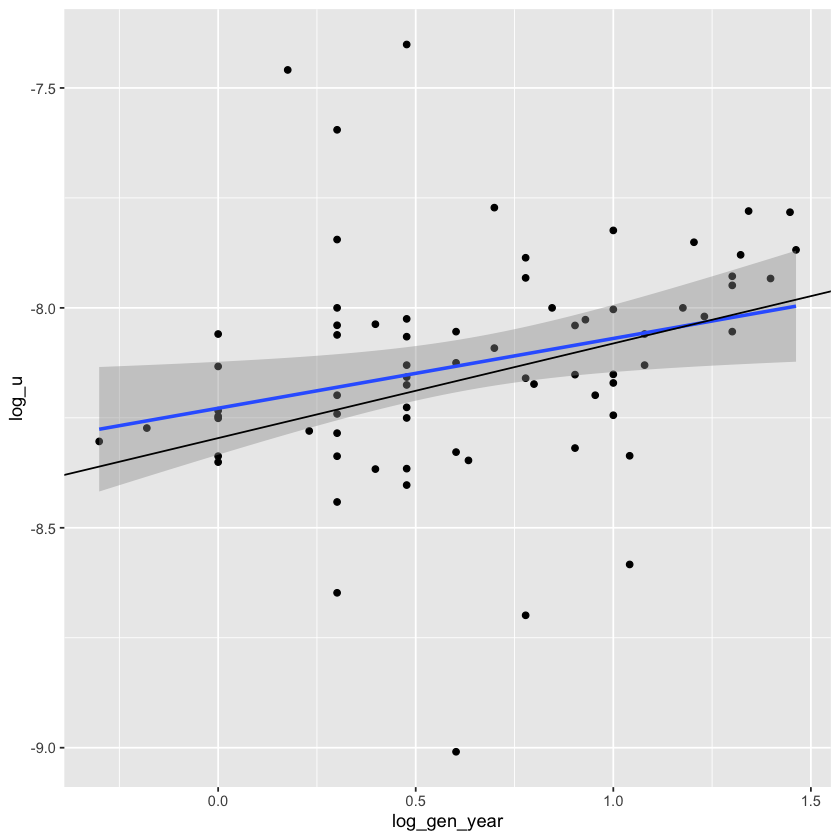

In [5]:
lambda = "ML" 
model.u_gen <- pgls_dbh(df, new_tree, "log_gen_year", "log_u", lambda=lambda, print_plot=TRUE)
summary(model.u_gen)
save_summary_data(model.u_gen, print_output=FALSE, save_output=TRUE, save_filename="output/r/mu_gen_vs_gen.csv")

## Figure 5 regressions

### Panel A: PGLS of effective population size on generation time (year)

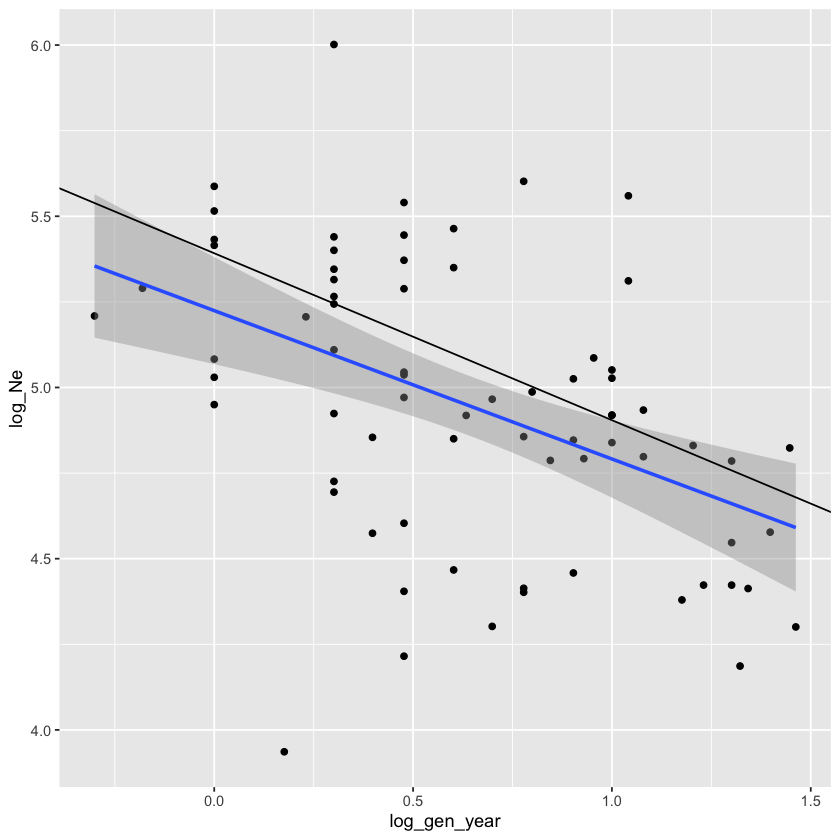

In [6]:
lambda = "ML" 
gen_Ne.pgls <- pgls_dbh(df, new_tree, "log_gen_year", "log_Ne", lambda=lambda, print_plot=TRUE)
# summary(gen_Ne.pgls)
save_summary_data(gen_Ne.pgls, print_output=FALSE, save_output=TRUE, save_filename="output/r/Ne_vs_gen.csv")

### Panel C: perform PGLS of mutation rate per year on Ne * gen  

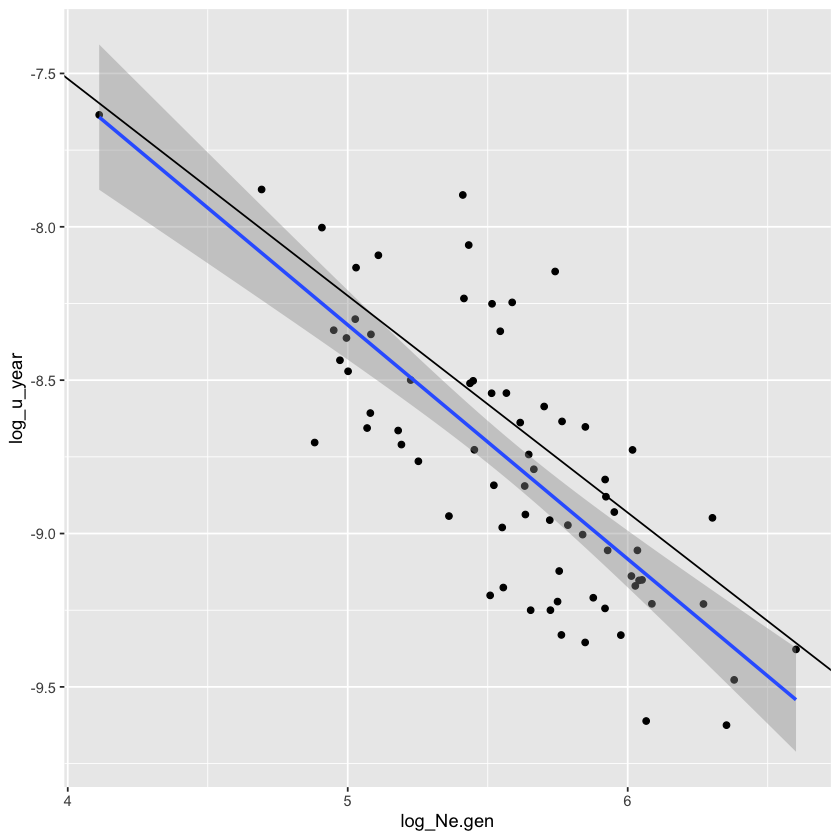

In [7]:
lambda = "ML" 
Negen_u_year.pgls <- pgls_dbh(df, new_tree, "log_Ne.gen", "log_u_year", lambda=lambda, print_plot=TRUE)
# summary(Negen_u.pgls)

print_output=FALSE
save_output=TRUE
save_summary_data(Negen_u_year.pgls, print_output=print_output, save_output=save_output, save_filename="output/r/dbh_vertebrate_u_year_vs_Negen.csv")

## Perform PGLS on gamete mutation rate per site per year and early embryonic mutation rate per site per generation on generation time (year)
Results are reported in figure 2

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


ERROR: Error in eval(predvars, data, env): object 'log_mu' not found


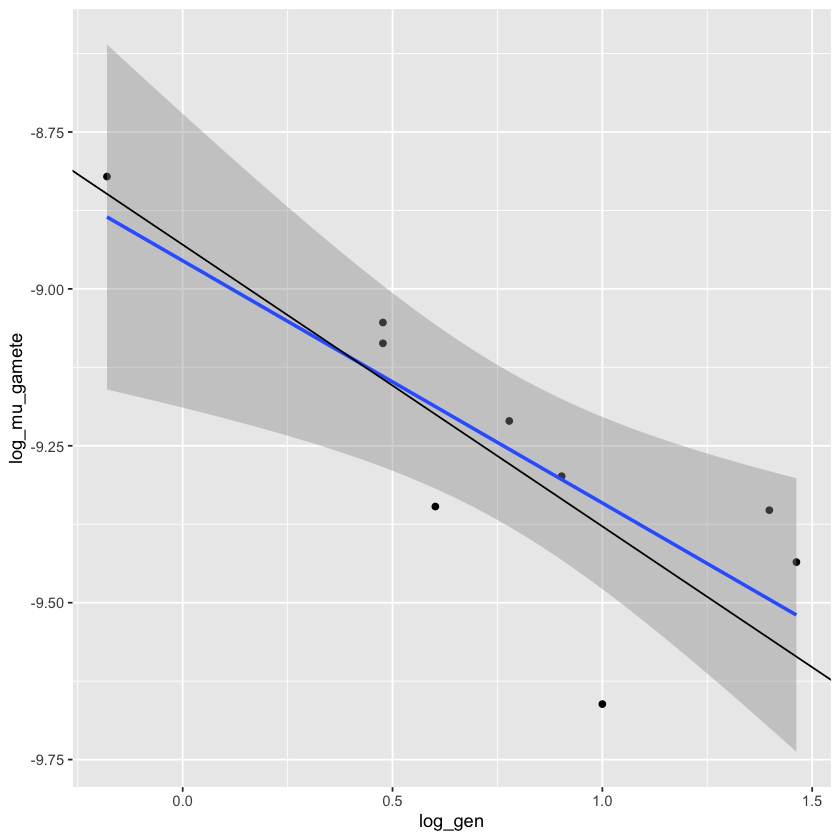

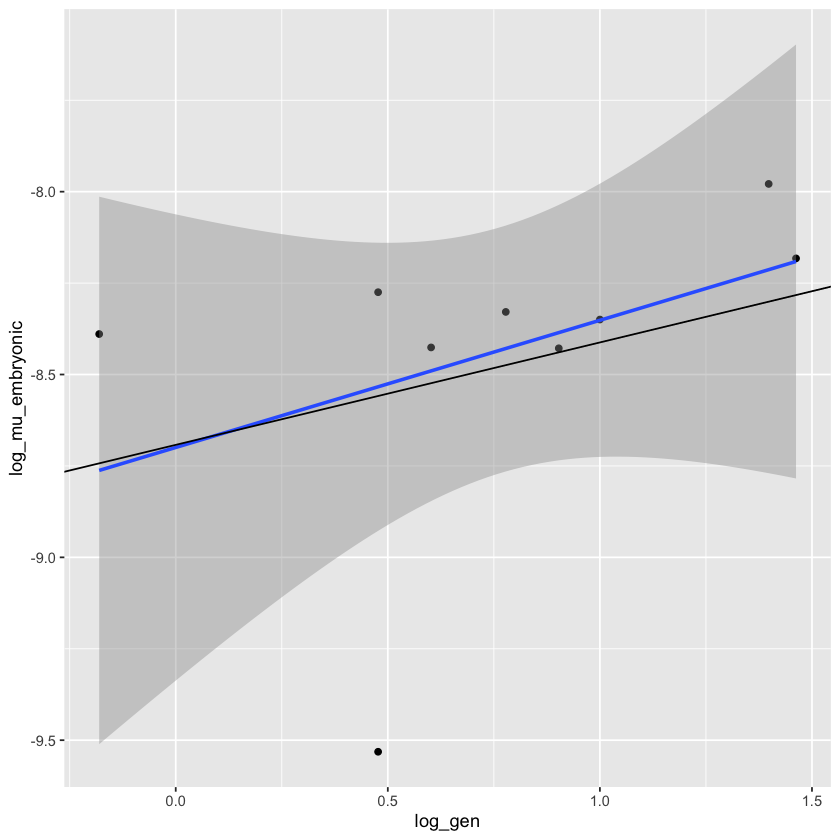

In [5]:
create_gamete_and_embroynic_mutation_rate_dataframe <- function() {
    # human, baboon, rhesus macaque, owl monkey, dog, cat, mouse, chimpanzee, aye-aye (gray mouse lemur)
    species <- c("Homo_sapiens_neanderthalensis", "Papio_anubis", "Macaca_mulatta_vestita", "Aotus_nancymaae", "Canis_lupus_familiaris", "Felis_catus", "Mus_musculus_musculus", "Pan_troglodytes", "Microcebus_murinus")
    embryonic_mutation_rate <- c(6.57e-9, 4.47e-9, 3.73e-9, 4.69e-9, 3.75e-9, 5.31e-9, 4.08e-9, 1.05e-8, 2.94e-10)
    gamete_mutation_rate <- c(3.67e-10, 2.18e-10, 5.03e-10, 6.16e-10, 4.5e-10, 8.19e-10, 1.51e-9, 4.44e-10, 8.84e-10)
    generation_time <- c(29, 10, 8, 6, 4, 3, 0.66, 25, 3)
    df <- data.frame(species=species, 
        mu_embryonic=embryonic_mutation_rate, 
        mu_gamete=gamete_mutation_rate, 
        gen=generation_time
    )
    df$log_mu_gamete <- log10(df$mu_gamete)
    df$log_mu_embryonic <- log10(df$mu_embryonic)
    df$log_gen <- log10(df$gen)
    rownames(df) <- df$species
    return(df)
}

perform_gamete_embroynic_data_regression <- function(lambda) {
    df_g_e <- create_gamete_and_embroynic_mutation_rate_dataframe()
    
    tree <- read.tree("./data/filtered_unique_species.nwk")
    # name_check <- name.check(tree, df_g_e)
    # tree_trim <- drop.tip(tree, name_check$tree_not_data)
    # name.check(tree_trim, df_g_e)
    # stopifnot(length(tree_trim$tip.label) == nrow(df_g_e))

    model.mu_gamete_gen <- pgls_dbh(df_g_e, tree, "log_gen", "log_mu_gamete", lambda, TRUE)
    save_summary_data(model.mu_gamete_gen, print_output=FALSE, save_output=TRUE, save_filename="output/r/longevity_model/mu_gamete_vs_generation_time.csv")
    
    model.mu_embryonic_gen <- pgls_dbh(df_g_e, tree, "log_gen", "log_mu_embryonic", lambda, TRUE)
    save_summary_data(model.mu_embryonic_gen, print_output=FALSE, save_output=TRUE, save_filename="output/r/longevity_model/mu_embryonic_vs_generation_time.csv")

    model.mu_gen <- pgls_dbh(df_g_e, tree, "log_gen", "log_mu", lambda, TRUE)
    save_summary_data(model.mu_gen, print_output=FALSE, save_output=TRUE, save_filename="output/r/longevity_model/mu_vs_generation_time.csv")
}

lambda <- "ML"
perform_gamete_embroynic_data_regression(lambda)